# Library

In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *

# Setting

## Path

In [2]:
path_input = '../input/kn/040Mpc/180s/med25nm/obs.000010.fits'
intbl = Table.read(path_input, format='fits')

In [3]:
path_model = '../model/PLAsTiCC/SNIax/SIMSED.SNIax/SED-Iax-0000.dat.fits'
mdtbl = Table.read(path_model, format='fits')

## Redshift interpolator for the fast calculation

In [4]:
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
from astropy import units as u
from astropy.cosmology import z_at_value

In [5]:
# z = 0.1
dL = np.arange(10, 1000+0.1, 0.1)*u.Mpc
zarr = z_at_value(cosmo.luminosity_distance, dL).value

In [6]:
# %%timeit
np.interp(13.51*u.Mpc, dL, zarr)

0.0031162562304217056

# Main

## Sample model

In [7]:
phasearr = np.unique(mdtbl['col1'])
lamarr = np.unique(mdtbl['col2'])
flux1darr = mdtbl['col3'].data
flux2darr = flux1darr.reshape(len(phasearr), len(lamarr))

Text(0.5, 1.0, '0.0d')

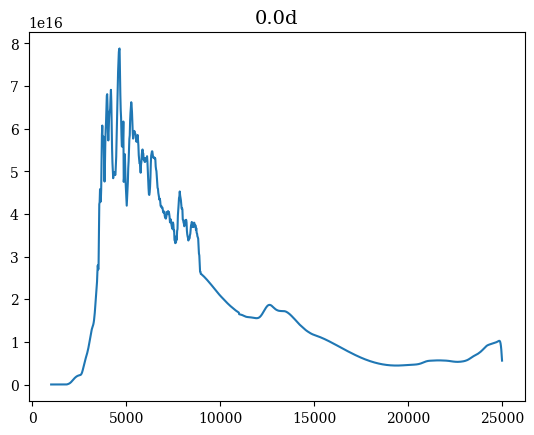

In [8]:
ii = 25
phase = phasearr[ii]
fluxarr = flux2darr[ii]
fnuarr = convert_flam2fnu(fluxarr*flamunit, lamarr*lamunit).to(u.uJy)

plt.plot(lamarr, fnuarr)
plt.title(f"{phase:.1f}d")

In [9]:
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [10]:
filterset = [f"{group}-{filte}" for filte, _, group in filterlist_med25nm]
bands = speclite.filters.load_filters(*filterset)

In [11]:
mags = bands.get_ab_magnitudes(*bands.pad_spectrum(fluxarr*flamunit, lamarr*lamunit)).to_pandas().to_numpy()[0]
fnu = (mags*u.ABmag).to(u.uJy)

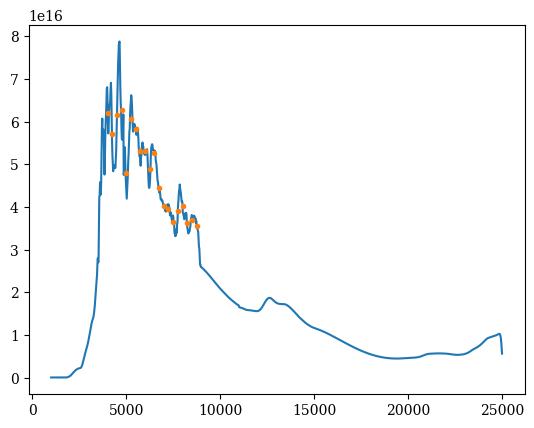

In [12]:
plt.plot(lamarr, fnuarr)
plt.plot(bands.effective_wavelengths, fnu, '.')

In [13]:
#	Distance as free parameter
d_free = 400*1e6 # [pc]
d_in = 10 # [pc]
distance_scaling = (d_in/d_free)**2
#	Redshift
zinterp = np.interp(d_free/1e6, dL.value, zarr)

In [14]:
(zspappflam, zsplam) = apply_redshift_on_spectrum(fluxarr*flamunit, lamarr*lamunit, z=zinterp, z0=0)

zmags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam)).to_pandas().to_numpy()[0]
zfnu = (zmags*u.ABmag).to(u.uJy)
zflam = convert_fnu2flam(zfnu, bands.effective_wavelengths)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


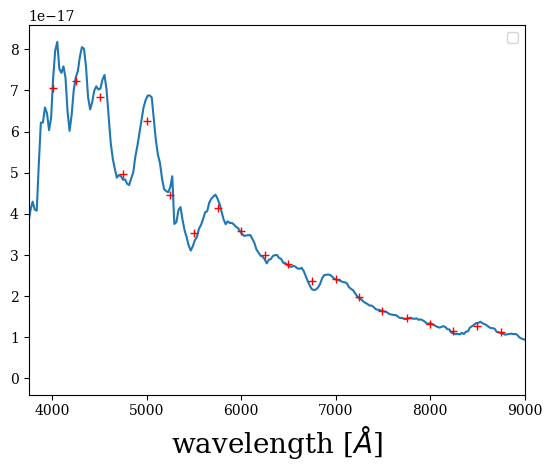

In [15]:
plt.plot(zsplam, zspappflam)
plt.plot(bands.effective_wavelengths, zflam, '+', c='r')

plt.xlim([3750, 9000])
# plt.ylabel(r'$f_{\nu}$ [Jy]')
plt.xlabel(r'wavelength [$\AA$]')
plt.legend()

In [36]:
len(phasearr)*1001*0.2

313.64666666666665

In [47]:
models = sorted(glob.glob('../model/PLAsTiCC/SNIax/SIMSED.SNIax/SED-*.dat.fits'))
print(f"{len(models)} models found")

1001 models found


In [72]:
lamarr[(lamarr>2000) & (lamarr<12000)]

1010.0
1030.0
1050.0
1070.0
1090.0
1110.0
1130.0
1150.0
1170.0
1190.0
1210.0


In [ ]:
# from scipy.interpolate import RegularGridInterpolator

# interp_dict = {}

# for mm, model in enumerate(models):
#     mdtbl = Table.read(model)
#     flux1darr = mdtbl['col3'][
#         (mdtbl['col2']>2000) & (mdtbl['col2']<12000) &
#         (mdtbl['col1']<=30)

#     ]
#     flux2darr = flux1darr.reshape(len(phasearr[phasearr<=30]), len(lamarr[(lamarr>2000) & (lamarr<12000)]))

#     interp = RegularGridInterpolator(
#         (phasearr[phasearr<=30], lamarr[(lamarr>2000) & (lamarr<12000)]),
#         flux2darr,
#         method='linear'
#     )
#     interp_dict[mm] = interp


In [77]:
from scipy.interpolate import RegularGridInterpolator

interp_dict = {}

for mm, model in enumerate(models):
    mdtbl = Table.read(model)
    flux2darr = mdtbl['col3'].data.reshape(len(phasearr), len(lamarr))

    interp = RegularGridInterpolator(
        (phasearr, lamarr),
        flux2darr,
        method='linear'
    )
    interp_dict[mm] = interp
    del mdtbl

In [78]:
xdata = intbl['fnuobs'].data
ydata = xdata
sigma = intbl['fnuerr'].data

In [81]:
chisqarr = np.zeros(len(models))

for mm, interp in interp_dict.items():

	def func(x, phase, z):
		point = (phase, lamarr)
		fluxarr = interp(point)
		(zspappflam, zsplam) = apply_redshift_on_spectrum(fluxarr*flamunit, lamarr*lamunit, z=z, z0=0)
		zmags = bands.get_ab_magnitudes(*bands.pad_spectrum(zspappflam, zsplam)).to_pandas().to_numpy()[0]
		zfnu = (zmags*u.ABmag).to(u.uJy).value
		# zflam = convert_fnu2flam(zfnu, bands.effective_wavelengths)
		return zfnu
	p0 = (
		0,
		0.05,
	)

	# %%timeit
	popt, pcov = curve_fit(
		func,
		xdata=xdata,
		ydata=ydata,
		sigma=sigma,
		p0=p0,
		absolute_sigma=True,
		check_finite=True,
		# bounds=bounds,
		method='trf',
		# max_nfev=1e4,
	)

	#	Fitting result
	r = ydata.data - func(xdata, *popt)
	# n_free_param = 3
	# ndet = len(intbl[indx_detection])
	# dof = ndet - n_free_param
	chisq_i = (r / sigma) ** 2
	chisq = np.sum(chisq_i)
	# chisqdof = chisq/dof
	# bic = chisq + n_free_param*np.log(ndet)
	perr = np.sqrt(np.diag(pcov))

	chisqarr[mm] = chisq
	if mm == 100:
		break
	print(f"{mm:0>4}: {popt[0]:.3}, {popt[1]:.3}")

0000: 0.344, 0.0768
0001: 0.194, 0.0325
0002: 2.91, 0.00776
0003: 0.025, 0.0197
0004: 0.332, 0.0209
0005: 0.579, 0.0741
0006: 2.91, 0.00761
0007: -6.95, 0.128
0008: 1.58, 0.068
0009: 1.82, 0.0442
0010: 0.844, 0.0161
0011: 0.347, 0.0771
0012: 1.97, 0.0121
0013: 2.93, 0.00728
0014: -0.0111, 0.0836
0015: 0.0363, 0.0281
0016: -6.1, 0.124
0017: 2.59, 0.0496
0018: 0.434, 0.112
0019: 2.85, 0.00836
0020: 1.81, 0.044
0021: 2.83, 0.00864
0022: 0.931, 0.0157
0023: 2.62, 0.0119
0024: 0.117, 0.0818
0025: 0.844, 0.103
0026: 0.0407, 0.0279
0027: -0.0701, 0.0828
0028: 0.526, 0.0187
0029: 2.47, 0.0471
0030: 0.332, 0.0343
0031: 2.81, 0.00904
0032: 0.362, 0.0349
0033: 0.455, 0.0951
0034: -0.0809, 0.0846
0035: 0.193, 0.0326
0036: 0.365, 0.0346
0037: 0.0806, 0.025
0038: 2.52, 0.0479
0039: 0.0856, 0.0241
0040: 2.55, 0.0484
0041: 0.0311, 0.026
0042: 0.788, 0.0167
0043: 0.125, 0.0807
0044: 2.64, 0.0509
0045: 0.539, 0.0368
0046: 0.274, 0.0216
0047: 1.59, 0.0679
0048: 0.169, 0.0318
0049: 0.0357, 0.0259
0050: 2.

In [67]:
chisqarr

array([ 79.12109117, 140.26133995,  96.98942945, ...,   0.        ,
         0.        ,   0.        ])

In [30]:
# %%timeit
popt, pcov = curve_fit(
	func,
	xdata=xdata,
	ydata=ydata,
	sigma=sigma,
	# p0=p0,
	absolute_sigma=True,
	check_finite=True,
	# bounds=bounds,
	method='trf',
	# max_nfev=1e4,
)

196 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
#	Fitting result
r = ydata.data - func(xdata, *popt)
# n_free_param = 3
# ndet = len(intbl[indx_detection])
# dof = ndet - n_free_param
chisq_i = (r / sigma) ** 2
chisq = np.sum(chisq_i)
# chisqdof = chisq/dof
# bic = chisq + n_free_param*np.log(ndet)
perr = np.sqrt(np.diag(pcov))

In [25]:
perr, chisq

(array([2.73725207e-06]), 79.59792283404768)

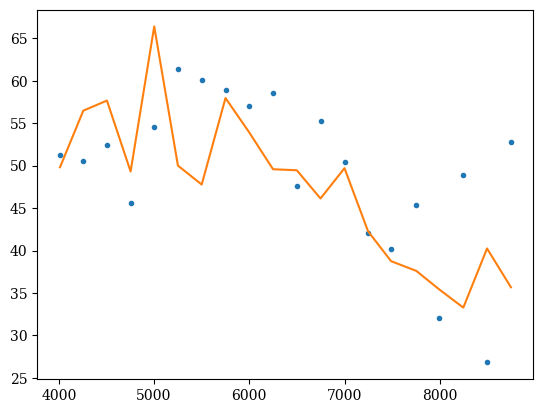

In [20]:
plt.plot(intbl['lam'], intbl['fnuobs'], '.')
plt.plot(intbl['lam'], func(xdata, *popt))